## **Importing necessary libraries**

In [ ]:
pip install ffmpeg-python

In [ ]:
#General
import numpy as np
import itertools
import pandas as pd

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

## **Getting the audio filenames**

In [ ]:
# Get files in data path
path='/content/drive/My Drive/PHILHARMONIA/Samples'
# Get Audio Files
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 4000 audio files in /content/drive/My Drive/PHILHARMONIA/Samples



## **Preparing Instrument labels from filenames**

In [ ]:
# Get Labels
labels =[]
classes=['flute','saxophone','oboe', 'cello','clarinet','viola','trombone','bassoon']
color_dict={'bassoon':'white','clarinet':'cyan','cello':'blue', 'flute':'red', 'oboe':'green', 'trombone':'black', 'saxophone':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## **Encoding the Instrument Labels**

In [ ]:
# Encode Labels to transform strings into numbers from 0 to n-1 classes
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

8 classes: bassoon, cello, clarinet, flute, oboe, saxophone, trombone, viola


## **Optimum Parameters for MFCC**

In [ ]:
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1      # Number of neighbors taken at the start for kNN Classifier 

## **Function to Calculate Audio Features: MFCC**

In [ ]:
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

## **Calculating and Creating feature vectors**

In [ ]:
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_B1_15_mezzo-piano_normal.mp3
get 2 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_D2_15_piano_normal.mp3
get 3 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_B1_025_piano_normal.mp3
get 4 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_Ds3_1_forte_normal.mp3
get 5 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_B4_05_mezzo-piano_normal.mp3
get 6 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_D3_1_piano_normal.mp3
get 7 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_Ds4_05_fortissimo_normal.mp3
get 8 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_E4_025_mezzo-piano_normal.mp3
get 9 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/bassoon_B1_15_forte_normal.mp3
get 10 of 4000 = /content/drive/My Drive/PHILHARMONIA/Samples/bassoon/basso

## **Standardization Of the Feature Vectors : Zero-Mean and Unit-Variance**







In [ ]:
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (4000, 13)


In [ ]:
scaled_feature_vectors

array([[ 0.72476009,  2.24315518,  1.20695772, ...,  0.67982798,
        -0.51881833, -0.82210024],
       [-0.28689599,  2.25180778,  2.46851221, ..., -0.76391995,
        -1.2374813 , -1.38535964],
       [-1.01140995,  1.32333074,  1.60475797, ...,  0.35495447,
        -0.43699351, -0.55345038],
       ...,
       [ 0.15762128, -0.18157952, -0.66424956, ..., -1.45029086,
         0.52710933,  0.69132798],
       [ 0.0570116 ,  0.22938777,  1.02023947, ...,  0.67451863,
         0.49416507,  0.4316541 ],
       [-0.11572172, -0.02995229,  0.429207  , ..., -0.24175542,
         0.6609405 ,  1.81696155]])

## **Creating Train and Test Sets**

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [ ]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (3000, 13)
test_set shape: (1000, 13)
train_classes shape: (3000,)
test_classes shape: (1000,)


## **Using KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1) # starting with number of neighbors =1

In [ ]:
knn.fit(train_set, train_classes)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
# Predict using the Test Set
predicted_labels = knn.predict(test_set)

## **Evaluations**

In [ ]:
# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Accuracy: 0.98  , 977
Number of samples: 1000


In [ ]:
print(classification_report(test_classes, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       125
           1       0.98      0.96      0.97       125
           2       0.98      0.98      0.98       125
           3       0.96      1.00      0.98       125
           4       1.00      0.96      0.98       125
           5       1.00      0.98      0.99       125
           6       0.98      0.99      0.99       125
           7       0.95      0.95      0.95       125

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [ ]:
# Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
# Recall - the ability of the classifier to find all the positive samples
# F1-Score - The F1 score can be interpreted as a weighted average of the precision and recall

## **Choosing a K Value**

In [ ]:
error_rate = []

for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_set, train_classes)
    pred_i = knn.predict(test_set)
    error_rate.append(np.mean(pred_i != test_classes))
    # wherever the pred value is not matching the test class value it will find the mean of that which will give the error rate.

Text(0, 0.5, 'Error Rate')

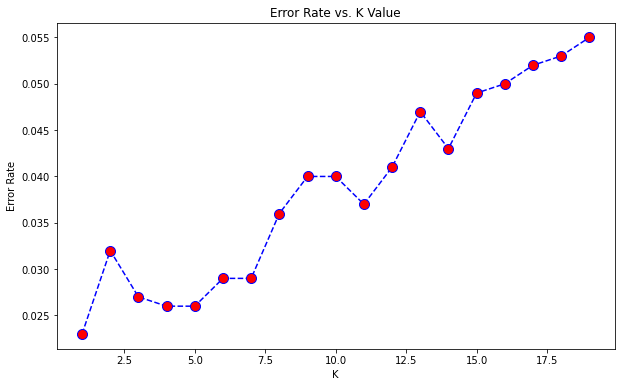

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

# **From the plot we see that the least stable error rate occurs around k =4 hence we will use k = 4 as the best model**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(train_set, train_classes)
# Predict using the Test Set
predicted_labels = knn.predict(test_set)

In [ ]:
# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Accuracy: 0.97  , 974
Number of samples: 1000


## **Creating Confusion Matrix**

In [ ]:
# Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

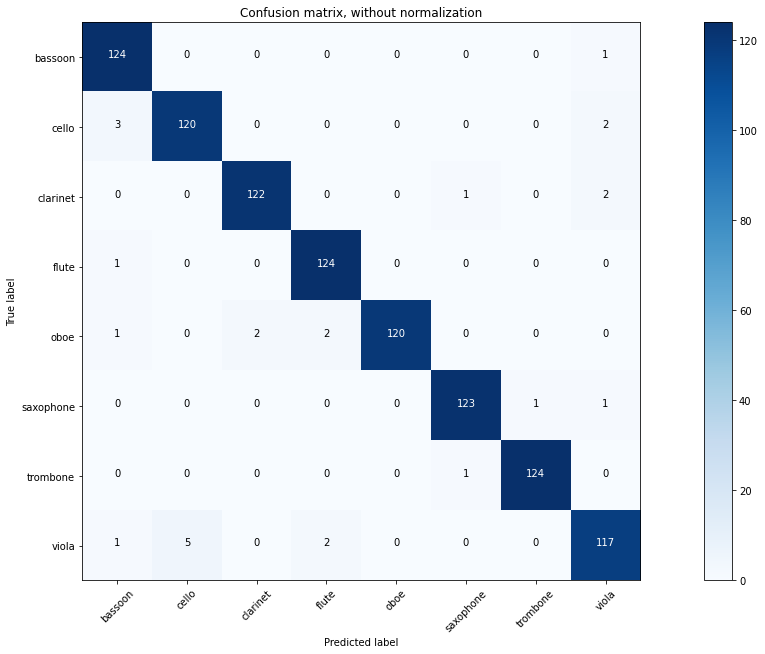

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,9))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')